# COP508 Machine Learning CW


Table of Contents:


## Data Ingestion


### Importing the libraries


In [2]:
import os
import numpy as np
import pickle
import requests
import matplotlib.pyplot as plt
import cv2
import wget
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import accuracy_score
from matplotlib import image
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras import optimizers
from keras.models import Sequential


### Importing the dataset from local machine


In [3]:
path_to_check = os.path.join('', 'image_recognition_dataset.pth')
data_path = path_to_check


def load_coursework_data():
    if not os.path.exists(path_to_check):
        print("Cannot find the dataset on local !")
        print("Downloading the dataset from cloud, it may take several mintues.")
        url = 'https://www.dropbox.com/s/j05hyf667ikzu4s/image_recognition_dataset.pth?dl=1'
        filename = wget.download(url)
        data_path = os.path.join('', filename)
    else:
        print("Data found on local {:s}".format(path_to_check))
        data_path = path_to_check

    data = pickle.load(open(data_path, 'rb'))
    train_imgs, train_labels, test_imgs, test_labels = data.values()
    return train_imgs, train_labels, test_imgs, test_labels


### Splitting the dataset into the Training & Test set


In [4]:
train_imgs, train_labels, test_imgs, test_labels = load_coursework_data()


Data found on local image_recognition_dataset.pth


### Displaying dataset information


In [5]:
cls_train = len(np.unique(train_labels))
print("Total number of image classes : {:d}".format(cls_train))
print("Shape of training set", train_imgs.shape)
print("Training image count: ", train_imgs.shape[0])
print("Test image count: ", test_imgs.shape[0])


Total number of image classes : 8
Shape of training set (40000, 32, 32, 3)
Training image count:  40000
Test image count:  8000


### Visualising five images from the dataset


/home/lunet/conm/.conda/envs/cop508/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


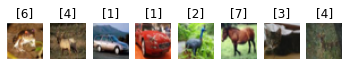

In [6]:
def plot_trained_images() -> None:
    for i in range(8):
        plt.subplot(1, 8, i+1)
        imgData = np.array(train_imgs[i])
        plt.title(train_labels[i])
        plt.imshow(imgData)
        plt.axis('off')


plot_trained_images()


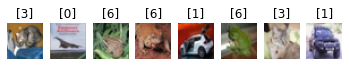

In [7]:
def plot_test_images() -> None:
    for i in range(8):
        plt.subplot(1, 8, i+1)
        imgData = np.array(test_imgs[i])
        plt.title(test_labels[i])
        plt.imshow(imgData)
        plt.axis('off')


plot_test_images()


## Data Preprocessing


### Gray scale conversion


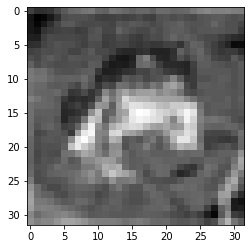

In [8]:
grayscale_train_img = [cv2.cvtColor(
    one_img, cv2.COLOR_BGR2GRAY) for one_img in train_imgs]
grayscale_test_img = [cv2.cvtColor(
    one_img, cv2.COLOR_BGR2GRAY) for one_img in test_imgs]
plt.imshow(grayscale_train_img[0], cmap='gray')


### Normalization


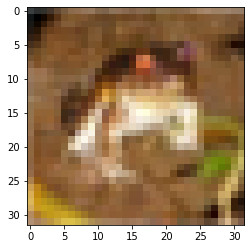

In [9]:
normalized_train_img = [one_img/255.0 for one_img in train_imgs]
normalized_test_img = [one_img/255.0 for one_img in test_imgs]
plt.imshow(normalized_train_img[0])


### Gaussian Blur


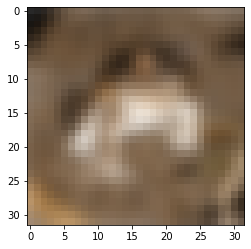

In [10]:
train_blurred_img = [ndimage.gaussian_filter(
    train_blur_imgs, sigma=1) for train_blur_imgs in normalized_train_img]
test_blurred_img = [ndimage.gaussian_filter(
    test_blur_imgs, sigma=1) for test_blur_imgs in normalized_test_img]
plt.imshow(train_blurred_img[0])


### Rotation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


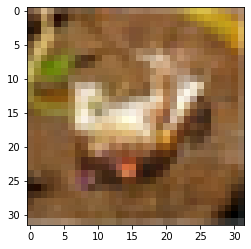

In [11]:
rotated_train_img = np.array([ndimage.rotate(
    train_rotate_imgs, angle=180) for train_rotate_imgs in normalized_train_img])
rotated_test_img = np.array([ndimage.rotate(
    test_rotate_imgs, angle=180) for test_rotate_imgs in normalized_test_img])
plt.imshow(rotated_train_img[0])


## Model Learning & Evaluation


### Convolutional Neural Network (CNN)


In [12]:
rotated_train_img = rotated_train_img.reshape(rotated_train_img.shape[0], 32, 32, 3)
rotated_test_img = rotated_test_img.reshape(rotated_test_img.shape[0], 32, 32, 3)
rotated_train_img = rotated_train_img.astype('float32')
rotated_test_img = rotated_test_img.astype('float32')

# one-hot encoding using keras' numpy-related utilities
n_classes = 8
print("Shape before one-hot encoding: ", train_labels.shape)
Y_train = np_utils.to_categorical(train_labels, n_classes)
Y_test = np_utils.to_categorical(test_labels, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (40000, 1)
Shape after one-hot encoding:  (40000, 8)


### Base CNN Model


In [13]:
# Reference:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', restore_best_weights=True, patience=0)
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 padding='same', input_shape=(32, 32, 3), activation='relu'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(
    1, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(
    1, 1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.55))
# output layer
model.add(Dense(8, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

# training the model for 20 epochs
final_model = model.fit(np.array(rotated_train_img), np.array(Y_train), batch_size=128, epochs=20, callbacks=[
                        early_callback], validation_data=(np.array(rotated_test_img), np.array(Y_test)))


2022-01-11 15:48:13.723256: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-11 15:48:13.723822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-11 15:48:13.782749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 15:48:13.783393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-11 15:48:13.783429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-11 15:48:13.820950: I tensorflow/stream_executor/platfor

Epoch 1/20


2022-01-11 15:48:14.921416: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-11 15:48:15.047069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


313/313 [==============================] - 5s 11ms/step - loss: 1.9213 - accuracy: 0.2308 - val_loss: 1.2775 - val_accuracy: 0.5222
Epoch 2/20
313/313 [==============================] - 3s 9ms/step - loss: 1.3512 - accuracy: 0.5043 - val_loss: 1.0864 - val_accuracy: 0.6152
Epoch 3/20
313/313 [==============================] - 3s 9ms/step - loss: 1.1723 - accuracy: 0.5735 - val_loss: 0.9709 - val_accuracy: 0.6518
Epoch 4/20
313/313 [==============================] - 3s 9ms/step - loss: 1.0793 - accuracy: 0.6120 - val_loss: 0.8918 - val_accuracy: 0.6894
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 1.0044 - accuracy: 0.6420 - val_loss: 0.8501 - val_accuracy: 0.7014
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 0.9374 - accuracy: 0.6709 - val_loss: 0.8024 - val_accuracy: 0.7180
Epoch 7/20
313/313 [==============================] - 3s 9ms/step - loss: 0.9210 - accuracy: 0.6746 - val_loss: 0.8058 - val_accuracy: 0.7146
Epoch 8/20
313

### VGG-16 (CNN) Model


In [15]:
# Reference: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
model1 = Sequential()

model1.add(Conv2D(32, input_shape=(32, 32, 3), kernel_size=(
    3, 3), strides=(1, 1), padding="same", activation="relu"))

model1.add(Conv2D(64, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(256, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(Conv2D(256, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(Conv2D(256, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(512, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(Conv2D(512, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(512, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(Conv2D(512, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(4096, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(4096, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation="softmax"))
model1.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy', 'AUC'])
vgg_model = model1.fit(rotated_train_img, Y_train, batch_size=128, epochs=10,
                       validation_data=(rotated_test_img, Y_test), callbacks=[early_callback])


Epoch 1/10
313/313 [==============================] - 9s 26ms/step - loss: 2.0812 - accuracy: 0.1251 - auc: 0.5007 - val_loss: 2.0796 - val_accuracy: 0.1250 - val_auc: 0.5000
Epoch 2/10
313/313 [==============================] - 8s 25ms/step - loss: 2.0798 - accuracy: 0.1236 - auc: 0.4980 - val_loss: 2.0795 - val_accuracy: 0.1250 - val_auc: 0.5000
Epoch 3/10
313/313 [==============================] - 8s 25ms/step - loss: 2.0796 - accuracy: 0.1303 - auc: 0.5009 - val_loss: 2.0795 - val_accuracy: 0.1250 - val_auc: 0.5000
Epoch 4/10
313/313 [==============================] - 8s 25ms/step - loss: 2.0795 - accuracy: 0.1266 - auc: 0.4992 - val_loss: 2.0795 - val_accuracy: 0.1250 - val_auc: 0.5000
Epoch 5/10
313/313 [==============================] - 8s 25ms/step - loss: 2.0796 - accuracy: 0.1210 - auc: 0.4974 - val_loss: 2.0795 - val_accuracy: 0.1250 - val_auc: 0.5000
Epoch 6/10
313/313 [==============================] - 8s 25ms/step - loss: 2.0794 - accuracy: 0.1233 - auc: 0.5039 - val_loss

### ResNet-50 (CNN) Model


In [17]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 32 x 32.
'''


def feature_extractor(inputs):

    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(32, 32, 3),
                                                              include_top=False,
                                                              weights='imagenet')(inputs)
    return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(8, activation="softmax",
                              name="classification")(x)
    return x


'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''


def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(1, 1))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''


def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800

In [18]:
model.fit(rotated_train_img, Y_train, epochs=10, validation_data=(rotated_test_img, Y_test))

Epoch 1/10
1250/1250 [==============================] - 26s 19ms/step - loss: 1.4135 - accuracy: 0.4962 - val_loss: 0.8872 - val_accuracy: 0.6991
Epoch 2/10
1250/1250 [==============================] - 23s 19ms/step - loss: 0.7568 - accuracy: 0.7345 - val_loss: 0.6585 - val_accuracy: 0.7781
Epoch 3/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.5570 - accuracy: 0.8041 - val_loss: 0.7812 - val_accuracy: 0.7352
Epoch 4/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4363 - accuracy: 0.8474 - val_loss: 0.6225 - val_accuracy: 0.7935
Epoch 5/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3456 - accuracy: 0.8779 - val_loss: 0.7298 - val_accuracy: 0.7657
Epoch 6/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2607 - accuracy: 0.9087 - val_loss: 0.7110 - val_accuracy: 0.7779
Epoch 7/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2121 - accuracy: 0.9255 - val_loss: 0.7273 -

KeyboardInterrupt: 

### Best Model (Adaptation from VGG16)


In [36]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', restore_best_weights=True, patience=10)
model2 = Sequential()
model2.add(Conv2D(32, input_shape=(32, 32, 3), kernel_size=(
    3, 3), strides=(1, 1), padding="same", activation="relu"))
model2.add(Conv2D(64, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(256, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(512, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(512, kernel_size=(3, 3), strides=(
    1, 1), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(500, activation="relu"))
model2.add(Dropout(0.75))
model2.add(Dense(200, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(8, activation="softmax"))
model2.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy'])
hist = model2.fit(rotated_train_img, Y_train, batch_size=128, callbacks=[
                  early_callback], epochs=25, validation_data=(rotated_test_img, Y_test))


Epoch 1/25
313/313 [==============================] - 4s 13ms/step - loss: 1.9911 - accuracy: 0.1835 - val_loss: 1.5644 - val_accuracy: 0.3902
Epoch 2/25
313/313 [==============================] - 4s 13ms/step - loss: 1.5009 - accuracy: 0.4309 - val_loss: 1.2025 - val_accuracy: 0.5587
Epoch 3/25
313/313 [==============================] - 4s 13ms/step - loss: 1.2365 - accuracy: 0.5468 - val_loss: 1.0702 - val_accuracy: 0.6166
Epoch 4/25
313/313 [==============================] - 4s 14ms/step - loss: 1.0817 - accuracy: 0.6071 - val_loss: 0.9983 - val_accuracy: 0.6415
Epoch 5/25
313/313 [==============================] - 4s 13ms/step - loss: 1.0032 - accuracy: 0.6379 - val_loss: 0.8751 - val_accuracy: 0.6898
Epoch 6/25
313/313 [==============================] - 4s 14ms/step - loss: 0.9168 - accuracy: 0.6754 - val_loss: 0.8914 - val_accuracy: 0.6877
Epoch 7/25
313/313 [==============================] - 4s 13ms/step - loss: 0.8817 - accuracy: 0.6905 - val_loss: 0.8361 - val_accuracy: 0.7111

## Model Evaluation


### Visualization of Base CNN Model


250/250 - 0s - loss: 0.6661 - accuracy: 0.7664
Test accuracy on test data split: 0.7663750052452087


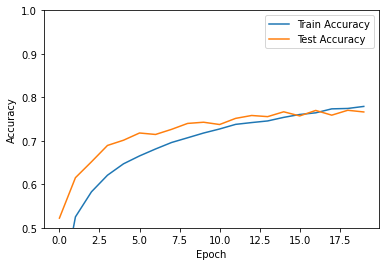

In [14]:
plt.plot(final_model.history['accuracy'], label='Train Accuracy')
plt.plot(final_model.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='best')

test_loss1, test_acc1, *_ = model.evaluate(rotated_test_img, Y_test, verbose=2)
print('Test accuracy on test data split:', test_acc1)


### Visualization of VGG-16 Model


In [ ]:
plt.plot(vgg_model.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_model.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='best')

test_loss2, test_acc2, *_ = model.evaluate(rotated_test_img, Y_test)
print('Test accuracy on test data split:', test_acc2)


### Visualization of Best Model (Adaptation from VGG16)


250/250 [==============================] - 1s 3ms/step - loss: 0.6553 - accuracy: 0.7715
Test accuracy on test data split: 0.7714999914169312


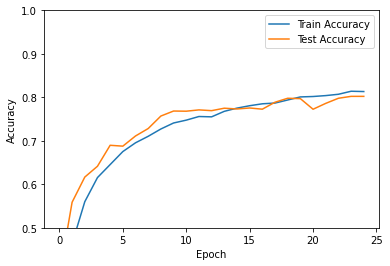

In [39]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='best')

test_loss3, test_acc3, *_ = model.evaluate(rotated_test_img, Y_test)
print('Test accuracy on test data split:', test_acc3)


## Model Launch/Prediction


### Prediction of Base CNN Model


In [24]:
classes = ['airplane', 'automobile', 'bird',
           'cat', 'deer', 'dog', 'frog', 'horse']


def display_images_prediction(digits, predictions, labels, title):
    n = 8

    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(8):
        ax = fig.add_subplot(1, 10, i+1)
        class_index = n_predictions[i]
        xlabel = 'Predicted:' + \
            classes[class_index] + '\n' + 'Actual:' + classes[n_labels[i]]
        plt.xlabel(xlabel)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])


TypeError: only integer scalar arrays can be converted to a scalar index

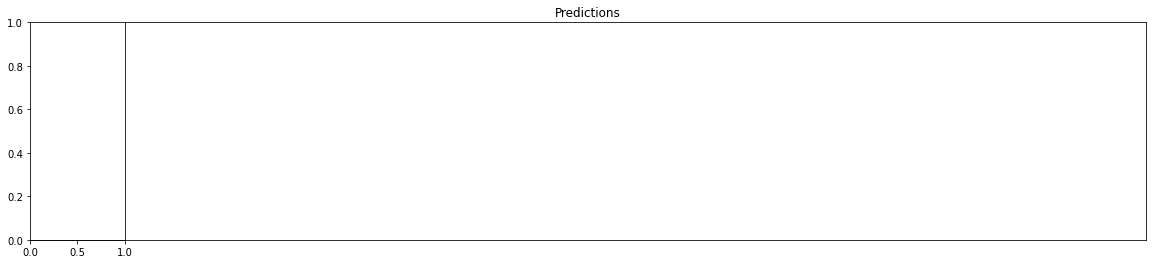

In [25]:
probabilities = model.predict(rotated_test_img, batch_size=128)
probabilities = np.argmax(probabilities, axis=1)

display_images_prediction(
    rotated_test_img, probabilities, Y_test, 'Predictions')
